In [1]:
import matplotlib.pyplot as plt
import numpy as np
from github.fbob.mplFOAM import mplfoam.py
import math
import ipywidgets as widgets

In [2]:
# To enable the ipympl backend, simply use the matplotlib Jupyter magic:
#%matplotlib widget

In [38]:
# Open the foam case
case = read_openfoam_case()

# Get the geometry bonds
data = servermanager.Fetch(case)
bounds = data.GetBounds()

# Get the timebounds of the simulation
    # Read the simpleFoam log file
directory = os.getcwd()
filename = os.path.join(directory, 'log.simpleFoam')
case_file = open(filename, 'r')
Lines = case_file.readlines()
case_file.close()

    # Iterative search inside the log file
min_time = -1
Max_time = 0
i = 0
while Lines[i] != "End\n" :
    if "Create mesh for time" in Lines[i] :
        min_time = float(Lines[i].split()[5])
    if "Time = " in Lines[i] and "ExecutionTime" not in Lines[i]:
        Max_time = float(Lines[i].split()[2])
    i+=1

Opening case file C:\Users\mypc\Documents\5A\Cours\PLP_5A\pipeCyclic\pipeCyclic\pipeCyclic.foam ...


In [39]:
def f(x_pos, y_pos, z_pos, Time, Normal) :
    return x_pos, y_pos, z_pos, Time, Normal

# Widget for the choice of x_pos
x_pos = widgets.BoundedFloatText(value=1.0, min=bounds[0], max=bounds[1], step=0.01, description='x_pos :',
    disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')

# Widget for the choice of y_pos
y_pos = widgets.FloatSlider(value=0, min=bounds[2], max=bounds[3], step=0.01, description='y_pos :',
    disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')

# Widget for the choice of z_pos
z_pos = widgets.BoundedFloatText(value=0, min=bounds[4], max=bounds[5], step=0.01, description='z_pos :',
    disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')

# Widget to choose the time
Time_choice = widgets.Combobox(placeholder='Type the wanted time, between '+str(min_time)+' and '+str(Max_time),
                               description='Time: ', 
                               disabled=False, layout=widgets.Layout(width="40%"))

# Widget to choose the normal : x, y or z
Normal_choice = widgets.Dropdown(options=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], value=[1, 0, 0], description='Normal :'
                                 , disabled=False)

widgets.interactive(f, x_pos=x_pos, y_pos=y_pos, z_pos=z_pos,Time=Time_choice, Normal=Normal_choice)

interactive(children=(BoundedFloatText(value=1.0, description='x_pos :', max=10.0, step=0.01), FloatSlider(val…

In [40]:
# Define the plane at position x_pos from which the data are extracted

origin = [x_pos.value, y_pos.value, z_pos.value]
time = int(Time_choice.value)
normal = Normal_choice.value

In [41]:
# Extract the defined plane
plane = plane_extract(case, slice_origin=origin, slice_normal=normal, time=time)

# Define the velocity components U=(u,v,w)
u, v, w = plane_vector_field(plane, 'U')

# Extract the cartesian coordinates of the triangulation points
x,y,z = plane_points(plane)

# Extract the triangulation of the plane
tri,triangles = plane_triangulation(plane)

# Extract the pressure
p = plane_scalar_field(plane, 'p')

# Compute the velocity magnitude
u_magnitude = np.sqrt(u**2 + v**2 + w**2)

Time= 800


In [42]:
def update_scales():
    # Definition of a proper layout for the rescaling widgets
    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='70%')
    
    # Creation of two widgets : one for rescaling the abscissa axis and one for the ordinate axis
    if normal == [1, 0, 0] :
        zoom_abs = widgets.FloatRangeSlider(value=[bounds[2], bounds[3]], min=bounds[2]-0.01, max=bounds[3]+0.02, 
                step=0.01, description='Rescale abscissa axis:', disabled=False, continuous_update=False,
                orientation='horizontal', readout=True, readout_format='.2f', layout=layout, style = style)
        zoom_ord = widgets.FloatRangeSlider(value=[bounds[4], bounds[5]], min=bounds[4]-0.01, max=bounds[5]+0.01, 
                step=0.01, description='Rescale ordinate axis:', disabled=False, continuous_update=False,
                orientation='horizontal', readout=True, readout_format='.2f', layout=layout, style = style)
    elif normal == [0, 1, 0] :
        zoom_abs = widgets.FloatRangeSlider(value=[bounds[0], bounds[1]], min=bounds[0]-0.01, max=bounds[1]+0.01, 
                step=0.01, description='Rescale abscissa axis:', disabled=False, continuous_update=False,
                orientation='horizontal', readout=True, readout_format='.2f', layout=layout, style = style)
        zoom_ord = widgets.FloatRangeSlider(value=[bounds[4], bounds[5]], min=bounds[4]-0.01, max=bounds[5]+0.01, 
                step=0.01, description='Rescale ordinate axis:', disabled=False, continuous_update=False,
                orientation='horizontal', readout=True, readout_format='.2f', layout=layout, style = style)
    else :
        zoom_abs = widgets.FloatRangeSlider(value=[bounds[0], bounds[1]], min=bounds[0]-0.01, max=bounds[1]+0.01, 
                step=0.01, description='Rescale abscissa axis:', disabled=False, continuous_update=False,
                orientation='horizontal', readout=True, readout_format='.2f', layout=layout, style = style)
        zoom_ord = widgets.FloatRangeSlider(value=[bounds[2], bounds[3]], min=bounds[2]-0.01, max=bounds[3]+0.01, 
                step=0.01, description='Rescale ordinate axis:', disabled=False, continuous_update=False,
                orientation='horizontal', readout=True, readout_format='.2f', layout=layout, style = style)
    return zoom_abs, zoom_ord

zoom_abs, zoom_ord = update_scales()


def visible(a, b, c, d, zoom1, zoom2) :
    if a == True :
        # Draw the mesh
        plt.figure("Mesh")
        plt.gca().set_aspect('equal')
        if normal == [1, 0, 0] :
            plt.triplot(y, z, tri, lw=0.5, color='black')
            plt.scatter(y, z, s=20, c='red', alpha=0.9)
            plt.xlabel(r'$y$')
            plt.ylabel(r'$z$')
            plt.title(r"Mesh at $x=$" + str(x_pos.value))
            plt.grid(linestyle=':')
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        elif normal == [0, 1, 0] :
            plt.triplot(x, z, tri, lw=0.5, color='black')
            plt.scatter(x, z, s=20, c='red', alpha=0.9)
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z$')
            plt.title(r"Mesh at $y=$" + str(y_pos.value))
            plt.grid(linestyle=':')
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        else :
            plt.triplot(x, y, tri, lw=0.5, color='black')
            plt.scatter(x, y, s=20, c='red', alpha=0.9)
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            plt.title(r"Mesh at $z=$" + str(z_pos.value))
            plt.grid(linestyle=':')
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        
    if b == True :
        # Draw the velocity contour with mesh
        plt.figure("Velocity")
        plt.gca().set_aspect('equal')
        if normal == [1, 0, 0] :
            plt.tripcolor(y, z, tri, w, shading='flat', edgecolors='black')
            plt.xlabel(r'$y$')
            plt.ylabel(r'$z$')
            plt.title(r"Velocity contours at $x=$" + str(x_pos.value))
            plt.grid(linestyle=':')
            cbar = plt.colorbar()
            cbar.set_label('Velocity', labelpad=10)
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        elif normal == [0, 1, 0] :
            plt.tripcolor(x, z, tri, u, shading='flat', edgecolors='black')
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z$')
            plt.title(r"Velocity contours at $y=$" + str(y_pos.value))
            plt.grid(linestyle=':')
            cbar = plt.colorbar()
            cbar.set_label('Velocity', labelpad=10)
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        else :
            plt.tripcolor(x, y, tri, v, shading='flat', edgecolors='black')
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            plt.title(r"Velocity contours at $z=$" + str(z_pos.value))
            plt.grid(linestyle=':')
            cbar = plt.colorbar()
            cbar.set_label('Velocity', labelpad=10)
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
    
    if c == True :
        # Draw the kinematic pressure contour with mesh
        plt.figure("Pressure")
        plt.gca().set_aspect('equal')
        if normal == [1, 0, 0] :
            plt.tripcolor(y, z, tri, p, shading='flat', edgecolors='black')
            plt.xlabel(r'$y$')
            plt.ylabel(r'$z$')
            plt.title(r"Kinematic pressure at $x=$" + str(x_pos.value))
            plt.grid(linestyle=':')
            cbar = plt.colorbar()
            cbar.set_label('Kinematic Pressure', labelpad=10)
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        elif normal == [0, 1, 0] :
            plt.tripcolor(x, z, tri, p, shading='flat', edgecolors='black')
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z$')
            plt.title(r"Kinematic pressure at $y=$" + str(y_pos.value))
            plt.grid(linestyle=':')
            cbar = plt.colorbar()
            cbar.set_label('Kinematic Pressure', labelpad=10)
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        else :
            plt.tripcolor(x, y, tri, p, shading='flat', edgecolors='black')
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            plt.title(r"Kinematic pressure at $z=$" + str(z_pos.value))
            plt.grid(linestyle=':')
            cbar = plt.colorbar()
            cbar.set_label('Kinematic Pressure', labelpad=10)
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
    
    if d == True :
        # Draw the velocity vector field
        plt.figure("Velocity Vectors")
        plt.gca().set_aspect('equal')
        if normal == [1, 0, 0] :
            plt.tripcolor(y, z, tri, np.zeros(np.size(x)), cmap=plt.cm.gray_r)
            plt.quiver(y, z, v, w)
            plt.xlabel(r'$y$')
            plt.ylabel(r'$z$')
            plt.title(r"Velocity vectors at $x=$" + str(x_pos.value))
            plt.grid(linestyle=':')
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        elif normal == [0, 1, 0] :
            plt.tripcolor(x, z, tri, np.zeros(np.size(y)), cmap=plt.cm.gray_r)
            plt.quiver(x, z, u, w)
            plt.xlabel(r'$x$')
            plt.ylabel(r'$z$')
            plt.title(r"Velocity vectors at $y=$" + str(y_pos.value))
            plt.grid(linestyle=':')
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
        else :
            plt.tripcolor(x, y, tri, np.zeros(np.size(z)), cmap=plt.cm.gray_r)
            plt.quiver(x, y, u, v)
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            plt.title(r"Velocity vectors at $z=$" + str(z_pos.value))
            plt.grid(linestyle=':')
            # Rescaling
            plt.axis(zoom_abs.value + zoom_ord.value)
    
    return a, b, c, d, zoom1, zoom2

see_mesh = widgets.Checkbox(value=False, description='Mesh', disabled=False)
see_Vcontour = widgets.Checkbox(value=False, description='Velocity contour', disabled=False)
see_Pcontour = widgets.Checkbox(value=False, description='Pressure contour', disabled=False)
see_Vvectors = widgets.Checkbox(value=False, description='Velocity vectors', disabled=False)

#linked = widgets.dlink((zoom_abs, 'value'), (visible))
widgets.interactive(visible, a=see_mesh, b=see_Vcontour, c=see_Pcontour, d=see_Vvectors, zoom1=zoom_abs, zoom2=zoom_ord)

interactive(children=(Checkbox(value=False, description='Mesh'), Checkbox(value=False, description='Velocity c…

In [43]:
# Define the repere in which we want to work, and the direction in which the PlotOverLine will be ploted
# Set also the coordinates in the cartesian repere (coordinates will be changed according to your repere chosen lately)
def g(repere, direction, coord11, coord12, coord21, coord22, coord31, coord32):
    return repere, direction, coord11, coord12, coord21, coord22, coord31, coord32

repere_choice = widgets.Dropdown(options=['Cartésien', 'Cylindrique', 'Sphérique'],
    value='Cartésien', description='Repère :', disabled=False)

direction_choice = widgets.Dropdown( options=['First coordinate', 'Second coordinate', 'Third coordinate'],
    value='First coordinate', description='Direction :', disabled=False)

coord11 = widgets.FloatSlider(value=1.0, min=bounds[0], max=bounds[1], step=0.1, 
    description='X1 :', disabled=False, continuous_update=False, orientation='horizontal',
    readout=True,readout_format='.2f')

coord12 = widgets.FloatSlider( value=1.0, min=bounds[0], max=bounds[1], step=0.1,
    description='X2 :', disabled=False, continuous_update=False, orientation='horizontal',
    readout=True,readout_format='.2f')

coord21 = widgets.FloatSlider(value=0.0, min=bounds[2], max=bounds[3], step=0.1,
    description='Y1 :', disabled=False, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='.2f')

coord22 = widgets.FloatSlider(value=0.0, min=bounds[2], max=bounds[3], step=0.1,
    description='Y2 :', disabled=False, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='.2f')

coord31 = widgets.FloatSlider(value=0.0, min=bounds[4], max=bounds[5], step=0.1,
    description='Z1 :', disabled=False, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='.2f')

coord32 = widgets.FloatSlider(value=0.0, min=bounds[4], max=bounds[5], step=0.1,
    description='Z2 :', disabled=False, continuous_update=False, orientation='horizontal',
    readout=True,readout_format='.2f')

widgets.interactive(g, repere=repere_choice, direction=direction_choice, coord11=coord11, coord12=coord12,
                    coord21=coord21, coord22=coord22, coord31=coord31, coord32=coord32)

interactive(children=(Dropdown(description='Repère :', options=('Cartésien', 'Cylindrique', 'Sphérique'), valu…

In [52]:
# Define the maximum value in the loop 'for'
def h(max):
    return(max)

if direction_choice.value == 'First coordinate':
    max_choice = widgets.IntSlider(
        value=7,
        min=0,
        max=bounds[1]-coord12.value,
        step=1,
        description="Valeur max de l'itération :",
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

elif direction_choice.value == 'Second coordinate':
    max_choice = widgets.IntSlider(
        value=7,
        min=0,
        max=bounds[3]-coord22.value,
        step=1,
        description="Valeur max de l'itération :",
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

else :
    max_choice = widgets.IntSlider(
        value=7,
        min=0,
        max=bounds[5]-coord32.value,
        step=1,
        description="Valeur max de l'itération :",
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )   

widgets.interactive(h,max=max_choice)

interactive(children=(IntSlider(value=7, continuous_update=False, description="Valeur max de l'itération :", m…

In [53]:
# Define the value of the step in the loop 'for'
def j(pas):
    return(pas)

pas_choice = widgets.IntSlider(
    value=1,
    min=1,
    max=max_choice.value,
    step=1,
    description="Valeur du pas de l'itération :",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widgets.interactive(j,pas=pas_choice)

interactive(children=(IntSlider(value=1, continuous_update=False, description="Valeur du pas de l'itération :"…

In [54]:
# Print the values of coordinates according to the repere chosen
if repere_choice.value == 'Cartésien':
    print('Les coordonées cartésiennes du point 1 sont :')
    print(coord11.value,coord21.value,coord31.value)
    print('Les coordonnées cartésiennes du point 2 sont :')
    print(coord12.value,coord22.value,coord32.value)

elif repere_choice.value == 'Cylindrique':
    r1, theta1 = cart2pol(coord11.value,coord21.value)
    r2, theta2 = cart2pol(coord12.value,coord22.value)
    print('Les coordonées cylindriques du point 1 sont :')
    print(r1,theta1,coord31.value)
    print('Les coordonnées cylindriques du point 2 sont :')
    print(r2,theta2,coord32.value)

else :
    az1, el1, r1 = cart2sph(coord11.value,coord21.value,coord31.value)
    az2, el2, r2 = cart2sph(coord12.value,coord22.value,coord32.value)
    print('Les coordonées sphériques du point 1 sont :')
    print(az1, el1, r1)
    print('Les coordonnées sphériques du point 2 sont :')
    print(az2, el2, r2)

Les coordonées cartésiennes du point 1 sont :
6.4 0.24645 0.3
Les coordonnées cartésiennes du point 2 sont :
2.5 0.04645 0.1


[[ 1.0061418   0.45700952 -0.37506938]
 [ 1.0061724   0.4568611  -0.3748972 ]
 [ 1.0062029   0.45671263 -0.374725  ]
 ...
 [ 1.0074022   0.20230646 -0.09412564]
 [ 1.007405    0.20191191 -0.09372871]
 [ 1.007408    0.20151737 -0.09333174]]
[[ 1.0053216   0.4011441  -0.32927555]
 [ 1.005351    0.40101373 -0.3291221 ]
 [ 1.0053804   0.40088332 -0.32896852]
 ...
 [ 1.0026801   0.17992121 -0.08416776]
 [ 1.0026621   0.17961636 -0.08383393]
 [ 1.0026441   0.17931132 -0.08349987]]
[[        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 ...
 [ 1.0071294   0.15433371 -0.07207192]
 [ 1.0071201   0.1540651  -0.07178259]
 [ 1.0071108   0.15379634 -0.0714931 ]]
[[        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 ...
 [ 1.0083228   0.12884372 -0.06011979]
 [ 1.0083177   0.12862031 -0.0598788 ]
 [ 1.0083126   0.12839672 -0.05963765]]


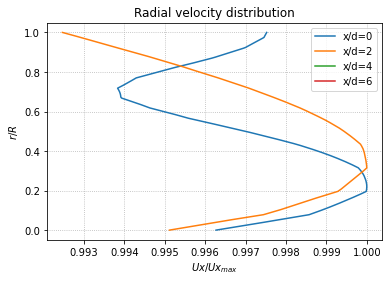

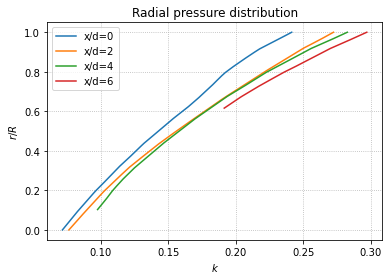

In [55]:
for i in range(0,max_choice.value,pas_choice.value):

    # Define the source data
    SetActiveSource(case)
    
    # Obtain the right valors of coordinates according to the repere chosen
    if repere_choice.value == 'Cartésien':
        x1, y1, z1 = coord11.value, coord21.value, coord31.value
        x2, y2, z2 = coord12.value, coord22.value, coord32.value
    
    elif repere_choice.value == 'Cylindrique':
        x1, y1, z1 = r1, theta1, Z1
        x2, y2, z2 = r2, theta2, Z2
    
    else:
        x1, y1, z1 = r1, el1, az1
        x2, y2, z2 = r2, el2, az2
    
    #Define the line according to the coordinate chosen
    if direction_choice.value == 'First coordinate' :
        PlotOverLine1 = PlotOverLine(Source="High Resolution Line Source")
        xPos = i
        PlotOverLine1.Source.Point1 = [x1 + xPos, y1, z1]
        PlotOverLine1.Source.Point2 = [x2 + xPos, y2, z2]
        
        # Transform the paraview arrays into numpy ones
        dataLine = servermanager.Fetch(PlotOverLine1)
        ULine = npvtk.vtk_to_numpy(dataLine.GetPointData().GetArray('U'))
        p = npvtk.vtk_to_numpy(dataLine.GetPointData().GetArray('k'))
        arcLength = npvtk.vtk_to_numpy(dataLine.GetPointData().GetArray('arc_length'))
        print(ULine)

        # Plots
        
        if repere_choice.value == 'Cartésien' :
            plt.figure("Velocity plot")
            plt.figure
            plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='x/d='+str(i))
            #plt.xlim(0,1)
            #plt.ylim(0,1.1)
            plt.xlabel(r'$Ux/Ux_{max}}$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial velocity distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
            plt.figure("P plot")
            plt.plot(p, arcLength/max(arcLength), label='x/d='+str(i))
            # xlim(0,1)
            # ylim(0,1.1)
            plt.xlabel(r'$k$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial pressure distribution")
            plt.legend()
            plt.grid(linestyle=':')
        
        else :
            plt.figure("Velocity plot")
            plt.figure
            plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='r/d='+str(i))
            #plt.xlim(0,1)
            #plt.ylim(0,1.1)
            plt.xlabel(r'$Ux/Ux_{max}}$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial velocity distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
            plt.figure("P plot")
            plt.plot(p, arcLength/max(arcLength), label='r/d='+str(i))
            # xlim(0,1)
            # ylim(0,1.1)
            plt.xlabel(r'$k$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial pressure distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
    
    
    elif direction_choice.value == 'Second coordinate' :
        PlotOverLine1 = PlotOverLine(Source="High Resolution Line Source")
        yPos = i
        PlotOverLine1.Source.Point1 = [x1, y1 + yPos, z1]
        PlotOverLine1.Source.Point2 = [x2, y2 + yPos, z2]
        
        # Plots
        
        if repere_choice.value == 'Cartésien' :
            plt.figure("Velocity plot")
            plt.figure
            plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='y/d='+str(i))
            #plt.xlim(0,1)
            #plt.ylim(0,1.1)
            plt.xlabel(r'$Ux/Ux_{max}}$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial velocity distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
            plt.figure("P plot")
            plt.plot(p, arcLength/max(arcLength), label='y/d='+str(i))
            # xlim(0,1)
            # ylim(0,1.1)
            plt.xlabel(r'$k$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial pressure distribution")
            plt.legend()
            plt.grid(linestyle=':')
        
        elif repere_choice.value == 'Cylindrique' :
            plt.figure("Velocity plot")
            plt.figure
            plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='theta/d='+str(i))
            #plt.xlim(0,1)
            #plt.ylim(0,1.1)
            plt.xlabel(r'$Ux/Ux_{max}}$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial velocity distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
            plt.figure("P plot")
            plt.plot(p, arcLength/max(arcLength), label='theta/d='+str(i))
            # xlim(0,1)
            # ylim(0,1.1)
            plt.xlabel(r'$k$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial pressure distribution")
            plt.legend()
            plt.grid(linestyle=':')
        
        else :
            plt.figure("Velocity plot")
            plt.figure
            plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='el/d='+str(i))
            #plt.xlim(0,1)
            #plt.ylim(0,1.1)
            plt.xlabel(r'$Ux/Ux_{max}}$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial velocity distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
            plt.figure("P plot")
            plt.plot(p, arcLength/max(arcLength), label='el/d='+str(i))
            # xlim(0,1)
            # ylim(0,1.1)
            plt.xlabel(r'$k$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial pressure distribution")
            plt.legend()
            plt.grid(linestyle=':')
        
        
    
    else :
        PlotOverLine1 = PlotOverLine(Source="High Resolution Line Source")
        zPos = i
        PlotOverLine1.Source.Point1 = [x1 , y1, z1 + zPos]
        PlotOverLine1.Source.Point2 = [x2 , y2, z2 + zPos]
        
        # Plots
        
        if repere_choice.value == 'Sphérique' :
            plt.figure("Velocity plot")
            plt.figure
            plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='az/d='+str(i))
            #plt.xlim(0,1)
            #plt.ylim(0,1.1)
            plt.xlabel(r'$Ux/Ux_{max}}$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial velocity distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
            plt.figure("P plot")
            plt.plot(p, arcLength/max(arcLength), label='az/d='+str(i))
            # xlim(0,1)
            # ylim(0,1.1)
            plt.xlabel(r'$k$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial pressure distribution")
            plt.legend()
            plt.grid(linestyle=':')
        
        else :
            plt.figure("Velocity plot")
            plt.figure
            plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='z/d='+str(i))
            #plt.xlim(0,1)
            #plt.ylim(0,1.1)
            plt.xlabel(r'$Ux/Ux_{max}}$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial velocity distribution")
            plt.legend()
            plt.grid(linestyle=':')
    
            plt.figure("P plot")
            plt.plot(p, arcLength/max(arcLength), label='z/d='+str(i))
            # xlim(0,1)
            # ylim(0,1.1)
            plt.xlabel(r'$k$')
            plt.ylabel(r'$r/R$')
            plt.title("Radial pressure distribution")
            plt.legend()
            plt.grid(linestyle=':')

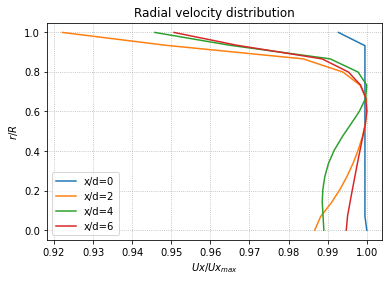

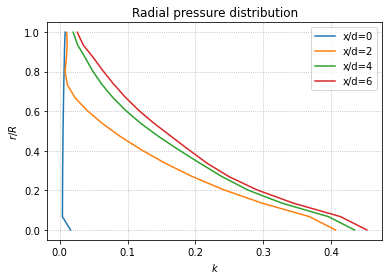

In [15]:
#
# PlotOverLine curve plots
#

R = 0.5
D = 2*R

# Define points coordinates in cylindrical coordinates
r1 = 0.0
r2 = R

theta1 = np.deg2rad(90)
theta2 = np.deg2rad(90)

x1 = 0
x2 = 0

# Transform points coordinates from cylindrical to cartesian
y1 = r1*math.cos(theta1)
y2 = r2*math.cos(theta2)

z1 = r1*math.sin(theta1)
z2 = r2*math.sin(theta2)


for i in range(0,7,2):

    # Define the source data
    SetActiveSource(case)

    # Define the line
    PlotOverLine1 = PlotOverLine(Source="High Resolution Line Source")
    xPos = i*D
    PlotOverLine1.Source.Point1 = [x1 + xPos, y1, z1]
    PlotOverLine1.Source.Point2 = [x2 + xPos, y2 ,z2]

    # Transform the paraview arrays into numpy ones
    dataLine = servermanager.Fetch(PlotOverLine1)
    ULine = npvtk.vtk_to_numpy(dataLine.GetPointData().GetArray('U'))
    p = npvtk.vtk_to_numpy(dataLine.GetPointData().GetArray('k'))
    arcLength = npvtk.vtk_to_numpy(dataLine.GetPointData().GetArray('arc_length'))

    # Plots
    plt.figure("Velocity plot")
    plt.figure
    plt.plot(ULine[:,0]/max(ULine[:,0]),arcLength/max(arcLength),label='x/d='+str(i))
    #plt.xlim(0,1)
    #plt.ylim(0,1.1)
    plt.xlabel(r'$Ux/Ux_{max}}$')
    plt.ylabel(r'$r/R$')
    plt.title("Radial velocity distribution")
    plt.legend()
    plt.grid(linestyle=':')
    
    plt.figure("P plot")
    plt.plot(p, arcLength/max(arcLength), label='x/d='+str(i))
    # xlim(0,1)
    # ylim(0,1.1)
    plt.xlabel(r'$k$')
    plt.ylabel(r'$r/R$')
    plt.title("Radial pressure distribution")
    plt.legend()
    plt.grid(linestyle=':')